# Import Packages

In [1]:
!pip install tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pulp
from pulp import *
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import clear_output
import time
from tqdm import tqdm
import itertools

# Part I

## Load Data

In [3]:
# Import Data 
df = pd.read_csv('player_sample.csv')
df['Price'] = df['Price'].fillna(0)
df.describe()

,Age,Previous App Purchases,Price
count,10000.000000,10000.000000,10000.000000
mean,36.588400,187.724300,1.811900
std,15.647053,81.677551,3.200069
min,11.000000,0.000000,0.000000
25%,27.000000,121.000000,0.000000
50%,32.000000,226.000000,0.000000
75%,39.000000,246.000000,2.500000
max,75.000000,312.000000,12.000000


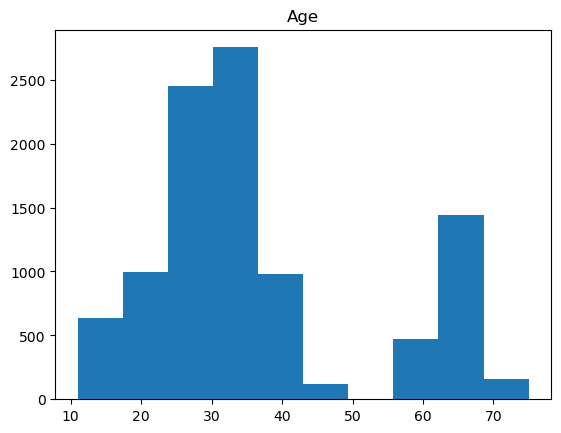

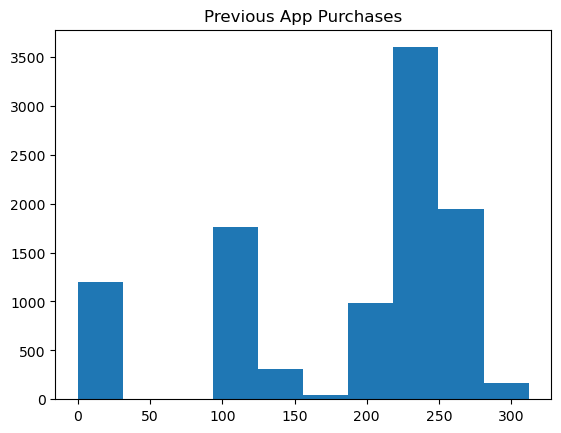

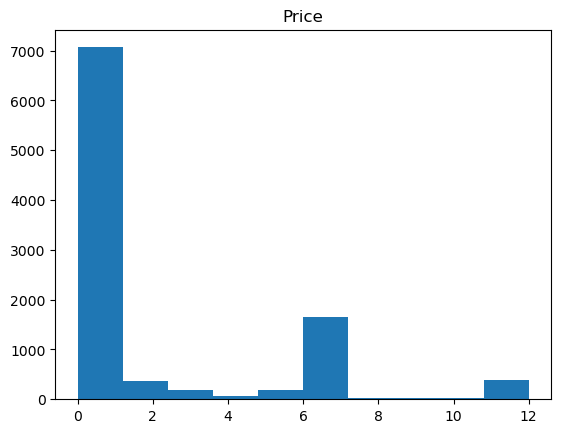

In [4]:
# Plot Distributions
for col in df.columns:
    plt.hist(df[col], bins=10)
    plt.title(col)
    plt.show()

## Question 1

In [5]:
# Get the count of each price
demand_df = pd.DataFrame(df['Price'].value_counts())
demand_df = demand_df.reset_index()
demand_df.columns = ['Price', 'Demand']

# Sort the prices, needed for next step
demand_df = demand_df.sort_values('Price', ascending = False)
demand_df = demand_df.reset_index()
demand_df = demand_df.drop('index', axis = 1)

# Display Table 
demand_df

,Price,Demand
0,12.0,368
1,11.0,11
2,10.0,21
3,9.0,30
4,8.0,34
5,7.0,479
6,6.0,1173
7,5.0,185
8,4.0,59
9,3.0,72


In [6]:
# Case Vars
num_people = 2000000
sample_size = 10000

demand_q1_df=demand_df.copy()

# Calc probability and cumulative sum
demand_q1_df['Probability'] = demand_q1_df['Demand'] / sum(demand_q1_df['Demand'])
demand_q1_df['CumulativeSum'] = demand_q1_df['Probability'].cumsum()

In [7]:
# Cumulative demand and its associated revenue 
demand_q1_df['CumulativeDemand'] = num_people * demand_q1_df['CumulativeSum']
demand_q1_df['CumulativeRevenue'] = demand_q1_df['Price'] * demand_q1_df['CumulativeDemand']

In [8]:
demand_q1_df

,Price,Demand,Probability,CumulativeSum,CumulativeDemand,CumulativeRevenue
0,12.0,368,0.0368,0.0368,73600.0,883200.0
1,11.0,11,0.0011,0.0379,75800.0,833800.0
2,10.0,21,0.0021,0.0400,80000.0,800000.0
3,9.0,30,0.0030,0.0430,86000.0,774000.0
4,8.0,34,0.0034,0.0464,92800.0,742400.0
5,7.0,479,0.0479,0.0943,188600.0,1320200.0
6,6.0,1173,0.1173,0.2116,423200.0,2539200.0
7,5.0,185,0.0185,0.2301,460200.0,2301000.0
8,4.0,59,0.0059,0.2360,472000.0,1888000.0
9,3.0,72,0.0072,0.2432,486400.0,1459200.0


In [9]:
# Find the optimal price
bestPrice_df = demand_q1_df.loc[demand_q1_df['CumulativeRevenue'] == demand_q1_df['CumulativeRevenue'].max()]
bestPrice_df

,Price,Demand,Probability,CumulativeSum,CumulativeDemand,CumulativeRevenue
6,6.0,1173,0.1173,0.2116,423200.0,2539200.0


<AxesSubplot:title={'center':'Demand vs Revenue'}, xlabel='Price'>

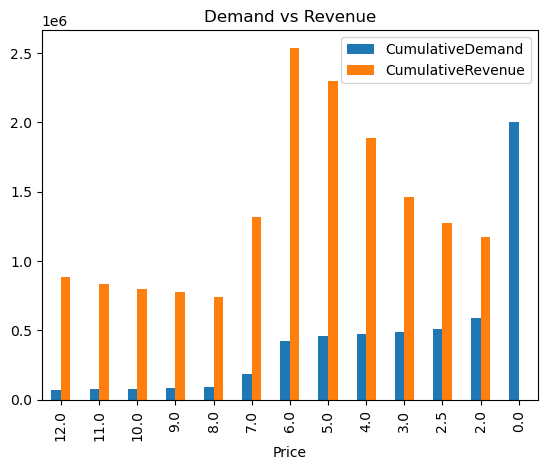

In [10]:
# Plot
demand_q1_df.plot.bar(x = 'Price', y = ['CumulativeDemand', 'CumulativeRevenue'], title = 'Demand vs Revenue')

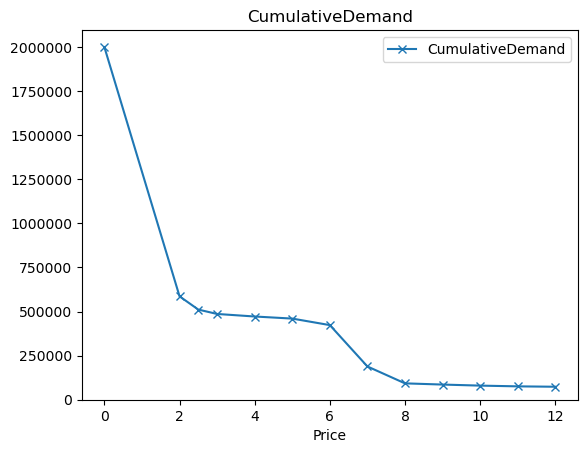

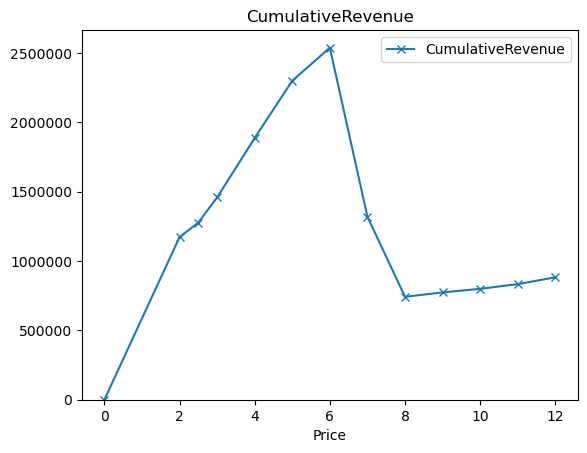

In [11]:
temp = ['CumulativeDemand', 'CumulativeRevenue']
for i in temp: 
    demand_q1_df.plot(x = 'Price', y = i, kind = 'line', marker = 'x')
    plt.ylim(ymin = 0)
    plt.title(i)
    plt.ticklabel_format(style = 'plain', axis = 'y')
    plt.show()

## Question 2

Text(0, 0.5, 'In App Spending')

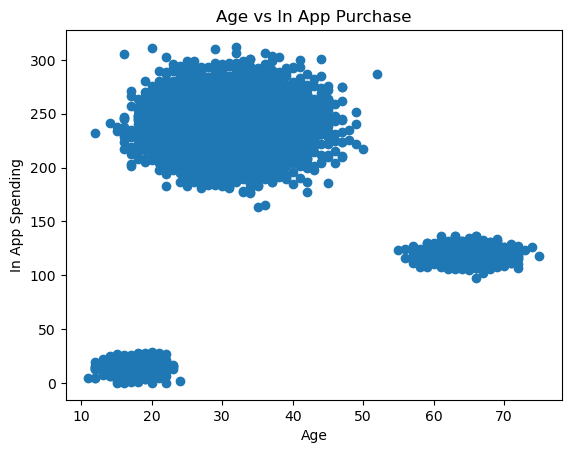

In [12]:
# Graph age vs in app spending
plt.scatter(x = df['Age'], y = df['Previous App Purchases'])
plt.title('Age vs In App Purchase')
plt.xlabel('Age')
plt.ylabel('In App Spending')

In [13]:
# Create new df
cluster_df = df.copy()
cluster_df.dropna(inplace = True)

# Create 3 clusters, confirmed visually
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(cluster_df)

# Get labels and centroids
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Add labels to the df
cluster_df['Cluster'] = labels

Text(0, 0.5, 'In App Spending')

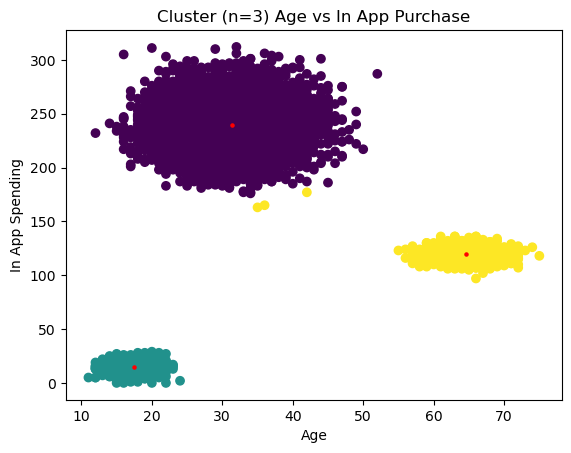

In [14]:
# Plot the clusters and the centroid (red)
plt.scatter(cluster_df['Age'], cluster_df['Previous App Purchases'], c = cluster_df['Cluster'])
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color = 'r', s = 5)

# Formatting graph
plt.title('Cluster (n=3) Age vs In App Purchase')
plt.xlabel('Age')
plt.ylabel('In App Spending')

In [15]:
# Define dict for storing results
cluster_revenues = {}

# Loop through the three clusters and find the max venue price for each
def cluster_revenue(cluster_df):
    revenue = 0
    for i in range(3):
        # Make temp df with matching cluster numbers
        temp_df = pd.DataFrame(cluster_df.loc[cluster_df['Cluster'] == i])
        
        # Get the count of each price
        temp_df = pd.DataFrame(temp_df['Price'].value_counts())
        temp_df = temp_df.reset_index()
        temp_df.columns = ['Price', 'Demand']

        # Sort the prices, needed for next step
        temp_df = temp_df.sort_values('Price', ascending = False)
        temp_df = temp_df.reset_index()
        temp_df = temp_df.drop('index', axis=1)

        # Calc probability and cumulative sum
        temp_df['Probability'] = temp_df['Demand'] / len(cluster_df.loc[cluster_df['Cluster'] == i])
        temp_df['CumulativeSum'] = temp_df['Probability'].cumsum()

        # Cumulative demand and its associated revenue 
        temp_df['CumulativeDemand'] =  temp_df['CumulativeSum'] * (len(cluster_df.loc[cluster_df['Cluster'] == i]) / sample_size) 
        temp_df['CumulativeRevenue'] = temp_df['Price'] * num_people * temp_df['CumulativeDemand']
        
        # Get highest revenue and add it to total
        highest_revenue = temp_df['CumulativeRevenue'].max()
        price = temp_df.loc[temp_df['CumulativeRevenue'] == highest_revenue]['Price'].values[0]
        revenue += highest_revenue
        
        # Print and add to dictionary
        print(f'Cluster: {i} has a revenue of ${highest_revenue} at Price: ${price}')
        
        cluster_revenues[i] = [price, highest_revenue]
        
    return revenue

# Call function and print results
revenue = cluster_revenue(cluster_df)
print(f'Sum of revenues: {revenue}')


Cluster: 0 has a revenue of $2011200.0 at Price: $6.0
Cluster: 1 has a revenue of $240000.0 at Price: $2.0
Cluster: 2 has a revenue of $883200.0 at Price: $12.0
Sum of revenues: 3134400.0


In [16]:
cluster_revenues

{0: [6.0, 2011200.0], 1: [2.0, 240000.0], 2: [12.0, 883200.0]}

# Part II

In [17]:
num_participant = num_people * 0.1*0.1
num_participant

20000.0

In [18]:
dfs = []
for _ in range(int(num_participant/sample_size)):
    dfs.append(cluster_df.copy())
customer_df = pd.concat(dfs, ignore_index=True)
del dfs
customer_df

,Age,Previous App Purchases,Price,Cluster
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1
...,...,...,...,...
19995,31,241,0.0,0
19996,25,265,0.0,0
19997,25,259,0.0,0
19998,68,115,0.0,2


In [19]:
customers = customer_df.index.to_list()

In [20]:
cluster_df.head()

,Age,Previous App Purchases,Price,Cluster
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1


In [21]:
# Tested base rates
base_rate_list = np.arange(1, 15.5, 0.5).tolist()

In [22]:
base_rate_list = [34]

In [23]:
# Constraint Variables
num_participant = num_people * 0.1
total_accepted_offers = 20000

discounts = []
i = 0.05
while i <= 1:
    discounts.append(i)
    i += 0.05
    
clusters_list = cluster_df['Cluster'].unique().tolist()

In [24]:
# Simulate the population of the participants of the event
dfs = []
for _ in range(int(num_participant/sample_size)):
    dfs.append(cluster_df.copy())
customer_df = pd.concat(dfs, ignore_index=True)
del dfs
customer_df.shape

(200000, 4)

In [25]:
best_revenue = 0
best_df = pd.DataFrame()
discount_record_dict = {}
for cluster in clusters_list:
    discount_record_dict[cluster] = 0.05

In [26]:
columns = ['Base_rate', 'Cluster_0_discount', 'Cluster_1_discount', 'Cluster_2_discount', 
           'Event_revenue', 'num_accpt_offers', 'num_deals', 'Revenue_without_offers', 
           'Regular_revenue', 'Total_revenue', 'Feasible']
log_df = pd.DataFrame(columns=columns)

In [27]:
def calculate_regular_revenue(base, num_not_participated, cluster_q2_df):
    
    cluster_q2_df['base'] = base
    rev = cluster_q2_df.loc[cluster_q2_df['Price']>= cluster_q2_df['base']]['base'].sum()
    rev = (num_not_participated/10000)*rev
    
    return rev

In [28]:
# k = 0
# for base in base_rate_list:
    
#     print('*******************************')
#     print('Base Rate:' + str(base) + " out of " + str(max(base_rate_list)))
#     log_df.loc[k, 'Base_rate'] = base
    
#     for cluster in clusters_list:
#         discount_record_dict[cluster] = 0.05
    
#     temp =  df.copy()
#     temp['base'] = base
#     temp_deals = temp.loc[temp['Price']>= temp['base']*0.95]['Price'].count() * \
#                 (num_participant/sample_size)
        
#     if temp_deals > total_accepted_offers:
#         print("total_accepted_offers exceeds the limit: " + str(temp_deals))
#         log_df.loc[k, 'Feasible'] = False
#         log_df.loc[k, 'Total_revenue'] = 0
#         continue
        
    
#     for cluster in clusters_list:
#         print('Change Cluster. \n Base Rate:' + str(base) + " out of " + str(max(base_rate_list)))
#         for discount in discounts:
#             search_df = customer_df.copy(deep=True)
#             discount_record_dict[cluster] = discount
#             total_num_accptd = 0
            
#             print('Cluster 0 discount:' + str(discount_record_dict[0]))
#             print('Cluster 1 discount:' + str(discount_record_dict[1]))
#             print('Cluster 2 discount:' + str(discount_record_dict[2]))
#             log_df.loc[k, 'Cluster_0_discount'] = discount_record_dict[0]
#             log_df.loc[k, 'Cluster_1_discount'] = discount_record_dict[1]
#             log_df.loc[k, 'Cluster_2_discount'] = discount_record_dict[2]
            
#             for c in clusters_list:
#                 search_df.loc[search_df['Cluster'] == c, 'Discount'] = discount_record_dict[c]
#                 search_df.loc[search_df['Cluster'] == c, 'Discounted Price'] = base * (1-discount_record_dict[c])
            
#             search_df.loc[search_df['Price'] >= search_df['Discounted Price'], 'Deal'] = 1 
#             search_df.loc[search_df['Price'] < search_df['Discounted Price'], 'Deal'] = 0
            

# #             for index, row in search_df.iterrows():
# #                 if search_df.loc[index, 'Price'] >= base * (1-discount_record_dict[search_df.loc[index, 'Cluster']]):
# #                     search_df.loc[index, 'Deal'] = 1
# #                     search_df.loc[index, 'Discount'] = discount_record_dict[search_df.loc[index, 'Cluster']]
# #                     search_df.loc[index, 'Discounted Price'] = base * (1-\
# #                                                                          discount_record_dict[search_df.loc[index, 'Cluster']])
# #                     total_num_accptd += 1
# #                     if total_num_accptd > total_accepted_offers:
# #                         break
# #                 else:
# #                     search_df.loc[index, 'Deal'] = 0
# #                     search_df.loc[index, 'Discount'] = discount_record_dict[search_df.loc[index, 'Cluster']]
# #                     search_df.loc[index, 'Discounted Price'] = base * (1-\
# #                                                                          discount_record_dict[search_df.loc[index, 'Cluster']])
            
#             if search_df['Deal'].sum() > total_accepted_offers:
#                 print('Wrong: total_accepted_offers exceeds the limit: ' + str(search_df['Deal'].sum()))
#                 log_df.loc[k, 'Total_revenue'] = 0
#                 log_df.loc[k, 'Base_rate'] = base
#                 log_df.loc[k, 'Feasible'] = False
#             else:
#                 log_df.loc[k, 'Base_rate'] = base
#                 log_df.loc[k, 'Event_revenue'] = search_df[search_df['Deal']==1]['Discounted Price'].sum()
#                 log_df.loc[k, 'Regular_revenue'] = calculate_regular_revenue(base, num_people-num_participant, df.copy())
#                 log_df.loc[k, 'num_accpt_offers'] = search_df['Deal'].sum()
#                 log_df.loc[k, 'num_deals'] = search_df['Deal'].sum()
#                 log_df.loc[k, 'Revenue_without_offers'] = calculate_regular_revenue(base, num_participant, df.copy())
#                 log_df.loc[k, 'Total_revenue'] = log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue']
#                 log_df.loc[k, 'Feasible'] = True
                
#                 print(log_df.loc[k])
                
#                 if (log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue'])>best_revenue:
#                     best_revenue = log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue']
#                     best_df = search_df.copy(deep=True)
                
#                 print('Current best strategy: ')
#                 display(log_df[log_df['Total_revenue'] == log_df['Total_revenue'].max()])
                
                
        
#             k += 1
        
# #         clear_output()
        
        

In [64]:
k = 0
for base in base_rate_list:
    
    print('*******************************')
    print('Base Rate:' + str(base) + " out of " + str(max(base_rate_list)))
    log_df.loc[k, 'Base_rate'] = base
    
    for cluster in clusters_list:
        discount_record_dict[cluster] = 0.05
    
    temp =  df.copy()
    temp['base'] = base
    temp_deals = temp.loc[temp['Price']>= temp['base']*0.95]['Price'].count() * \
                (num_participant/sample_size)
        
    if temp_deals > total_accepted_offers:
        print("total_accepted_offers exceeds the limit: " + str(temp_deals))
        log_df.loc[k, 'Feasible'] = False
        log_df.loc[k, 'Total_revenue'] = calculate_regular_revenue(base, num_people, df.copy())
        k += 1
        continue
        
    for combination in itertools.product(discounts, discounts, discounts):
        search_df = customer_df.copy(deep=True)
        log_df.loc[k, 'Cluster_0_discount'] = combination[0]
        log_df.loc[k, 'Cluster_1_discount'] = combination[1]
        log_df.loc[k, 'Cluster_2_discount'] = combination[2]
        print('Cluster 0 discount:' + str(combination[0]))
        print('Cluster 1 discount:' + str(combination[1]))
        print('Cluster 2 discount:' + str(combination[2]))   
            
        for c in clusters_list:
            search_df.loc[search_df['Cluster'] == c, 'Discount'] = combination[c]
            search_df.loc[search_df['Cluster'] == c, 'Discounted Price'] = base * (1-combination[c])

        search_df.loc[search_df['Price'] >= search_df['Discounted Price'], 'Deal'] = 1 
        search_df.loc[search_df['Price'] < search_df['Discounted Price'], 'Deal'] = 0

        if search_df['Deal'].sum() > total_accepted_offers:
            print('Wrong: total_accepted_offers exceeds the limit: ' + str(search_df['Deal'].sum()))
            log_df.loc[k, 'Base_rate'] = base
            log_df.loc[k, 'Feasible'] = False
            log_df.loc[k, 'num_accpt_offers'] = search_df['Deal'].sum()
            log_df.loc[k, 'Total_revenue'] = calculate_regular_revenue(base, num_people, df.copy())
        else:
            log_df.loc[k, 'Base_rate'] = base
            log_df.loc[k, 'Event_revenue'] = search_df[search_df['Deal']==1]['Discounted Price'].sum()
            log_df.loc[k, 'Regular_revenue'] = calculate_regular_revenue(base, num_people-num_participant, df.copy())
            log_df.loc[k, 'num_accpt_offers'] = search_df['Deal'].sum()
            log_df.loc[k, 'num_deals'] = search_df['Deal'].sum()
            log_df.loc[k, 'Revenue_without_offers'] = calculate_regular_revenue(base, num_participant, df.copy())
            log_df.loc[k, 'Total_revenue'] = log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue']
            log_df.loc[k, 'Feasible'] = True

            print(log_df.loc[k])

            if (log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue'])>best_revenue:
                best_revenue = log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue']
                best_df = search_df.copy(deep=True)

            print('Current best strategy: ')
            display(log_df[log_df['Total_revenue'] == log_df['Total_revenue'].max()])
                
                
        
        k += 1
        if k%50==0:
            clear_output()
        
        
        

Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.5499999999999999
Wrong: total_accepted_offers exceeds the limit: 50040.0
Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.6
Wrong: total_accepted_offers exceeds the limit: 50040.0
Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.65
Wrong: total_accepted_offers exceeds the limit: 57400.0
Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.7000000000000001
Wrong: total_accepted_offers exceeds the limit: 57620.0
Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.7500000000000001
Wrong: total_accepted_offers exceeds the limit: 58440.0
Cluster 0 discount:0.9500000000000003
Cluster 1 discount:0.9500000000000003
Cluster 2 discount:0.8000000000000002
Wrong: total_accepted_offers exceeds the limit: 58640.0
Cluster 0

## The best solution when the event is optional

In [36]:
display(log_df[log_df['Total_revenue'] == log_df['Total_revenue'].max()])

,Base_rate,Cluster_0_discount,Cluster_1_discount,Cluster_2_discount,Event_revenue,num_accpt_offers,num_deals,Revenue_without_offers,Regular_revenue,Total_revenue,Feasible
5750,34,0.8,0.9,0.65,158984.0,18140.0,18140.0,0.0,0.0,158984.0,True


## The best solution when the event is held

In [136]:
feasible_df = log_df[log_df['Feasible'] == True]
display(feasible_df[feasible_df['Total_revenue'] == feasible_df['Total_revenue'].max()])

,Base_rate,Cluster_0_discount,Cluster_1_discount,Cluster_2_discount,Event_revenue,num_accpt_offers,num_deals,Revenue_without_offers,Regular_revenue,Total_revenue,Feasible
7022,7.0,0.05,0.45,0.05,127309.0,19380.0,19380.0,132020.0,1188180.0,1315489.0,True


## The best solution when the revenue from the event is maximized

In [137]:
display(feasible_df[feasible_df['Event_revenue'] == feasible_df['Event_revenue'].max()])

,Base_rate,Cluster_0_discount,Cluster_1_discount,Cluster_2_discount,Event_revenue,num_accpt_offers,num_deals,Revenue_without_offers,Regular_revenue,Total_revenue,Feasible
106432,14.0,0.5,0.8,0.15,164724.0,19580.0,19580.0,0.0,0.0,164724.0,True


In [60]:
discounts

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35,
 0.39999999999999997,
 0.44999999999999996,
 0.49999999999999994,
 0.5499999999999999,
 0.6,
 0.65,
 0.7000000000000001,
 0.7500000000000001,
 0.8000000000000002,
 0.8500000000000002,
 0.9000000000000002,
 0.9500000000000003]

In [68]:
log_df[(log_df['Cluster_0_discount'].astype(float)==0.8500000000000002) & (log_df['Cluster_1_discount'].astype(float)==0.8500000000000002)&(log_df['Cluster_2_discount'].astype(float)==0.39999999999999997)]

,Base_rate,Cluster_0_discount,Cluster_1_discount,Cluster_2_discount,Event_revenue,num_accpt_offers,num_deals,Revenue_without_offers,Regular_revenue,Total_revenue,Feasible
6087,34,0.85,0.85,0.4,NaN,33720.0,NaN,NaN,NaN,0.0,False


In [69]:
combination = (0.8500000000000002, 0.8500000000000002, 0.39999999999999997)
search_df = customer_df.copy(deep=True)
log_df.loc[k, 'Cluster_0_discount'] = combination[0]
log_df.loc[k, 'Cluster_1_discount'] = combination[1]
log_df.loc[k, 'Cluster_2_discount'] = combination[2]
print('Cluster 0 discount:' + str(combination[0]))
print('Cluster 1 discount:' + str(combination[1]))
print('Cluster 2 discount:' + str(combination[2]))   

for c in clusters_list:
    search_df.loc[search_df['Cluster'] == c, 'Discount'] = combination[c]
    search_df.loc[search_df['Cluster'] == c, 'Discounted Price'] = base * (1-combination[c])

search_df.loc[search_df['Price'] >= search_df['Discounted Price'], 'Deal'] = 1 
search_df.loc[search_df['Price'] < search_df['Discounted Price'], 'Deal'] = 0

if search_df['Deal'].sum() > total_accepted_offers:
    print('Wrong: total_accepted_offers exceeds the limit: ' + str(search_df['Deal'].sum()))
    log_df.loc[k, 'Base_rate'] = base
    log_df.loc[k, 'Feasible'] = False
    log_df.loc[k, 'num_accpt_offers'] = search_df['Deal'].sum()
    log_df.loc[k, 'Total_revenue'] = calculate_regular_revenue(base, num_people, df.copy())
else:
    log_df.loc[k, 'Base_rate'] = base
    log_df.loc[k, 'Event_revenue'] = search_df[search_df['Deal']==1]['Discounted Price'].sum()
    log_df.loc[k, 'Regular_revenue'] = calculate_regular_revenue(base, num_people-num_participant, df.copy())
    log_df.loc[k, 'num_accpt_offers'] = search_df['Deal'].sum()
    log_df.loc[k, 'num_deals'] = search_df['Deal'].sum()
    log_df.loc[k, 'Revenue_without_offers'] = calculate_regular_revenue(base, num_participant, df.copy())
    log_df.loc[k, 'Total_revenue'] = log_df.loc[k, 'Event_revenue'] + log_df.loc[k, 'Regular_revenue']
    log_df.loc[k, 'Feasible'] = True

Cluster 0 discount:0.8500000000000002
Cluster 1 discount:0.8500000000000002
Cluster 2 discount:0.39999999999999997
Wrong: total_accepted_offers exceeds the limit: 33720.0


In [73]:
search_df

,Age,Previous App Purchases,Price,Cluster,Discount,Discounted Price,Deal
0,37,218,6.0,0,0.85,5.1,1.0
1,34,247,6.0,0,0.85,5.1,1.0
2,19,15,4.0,1,0.85,5.1,0.0
3,32,235,7.0,0,0.85,5.1,1.0
4,19,15,2.5,1,0.85,5.1,0.0
...,...,...,...,...,...,...,...
199995,31,241,0.0,0,0.85,5.1,0.0
199996,25,265,0.0,0,0.85,5.1,0.0
199997,25,259,0.0,0,0.85,5.1,0.0
199998,68,115,0.0,2,0.40,20.4,0.0


In [31]:
best_df

,Age,Previous App Purchases,Price,Cluster,Discount,Discounted Price,Deal
0,37,218,6.0,0,0.80,6.8,0.0
1,34,247,6.0,0,0.80,6.8,0.0
2,19,15,4.0,1,0.90,3.4,1.0
3,32,235,7.0,0,0.80,6.8,1.0
4,19,15,2.5,1,0.90,3.4,0.0
...,...,...,...,...,...,...,...
199995,31,241,0.0,0,0.80,6.8,0.0
199996,25,265,0.0,0,0.80,6.8,0.0
199997,25,259,0.0,0,0.80,6.8,0.0
199998,68,115,0.0,2,0.65,11.9,0.0


## Plots

In [139]:
log_df

,Base_rate,Cluster_0_discount,Cluster_1_discount,Cluster_2_discount,Event_revenue,num_accpt_offers,num_deals,Revenue_without_offers,Regular_revenue,Total_revenue,Feasible,Revenue_increase
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,586400.0,False,NaN
1,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,879600.0,False,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1172800.0,False,NaN
3,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1278000.0,False,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1459200.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
123468,15.0,0.95,0.95,0.75,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN
123469,15.0,0.95,0.95,0.8,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN
123470,15.0,0.95,0.95,0.85,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN
123471,15.0,0.95,0.95,0.9,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN


In [138]:
log_df['Revenue_increase'] = log_df['Event_revenue'] - log_df['Revenue_without_offers']

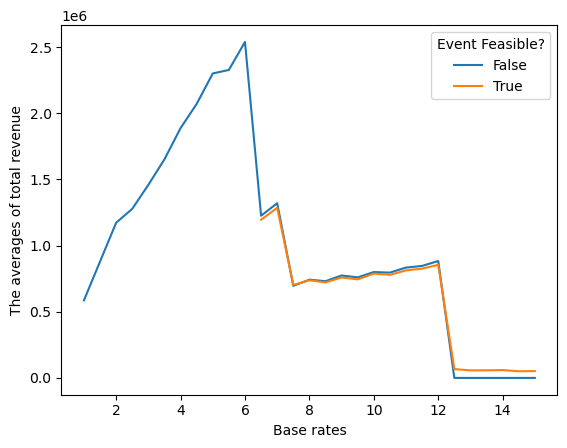

In [131]:
grouped = log_df.groupby(['Base_rate', 'Feasible']).mean().reset_index()

for category, group in grouped.groupby('Feasible'):
    plt.plot(group['Base_rate'], group['Total_revenue'], label=category)
plt.xlabel('Base rates')
plt.ylabel('The averages of total revenue')
plt.legend(title='Event Feasible?')
plt.show()

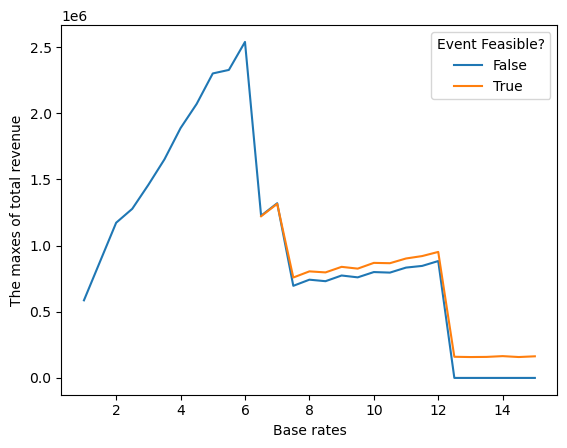

In [132]:
grouped = log_df.groupby(['Base_rate', 'Feasible']).max().reset_index()

for category, group in grouped.groupby('Feasible'):
    plt.plot(group['Base_rate'], group['Total_revenue'], label=category)
plt.xlabel('Base rates')
plt.ylabel('The maxes of total revenue')
plt.legend(title='Event Feasible?')
plt.show()

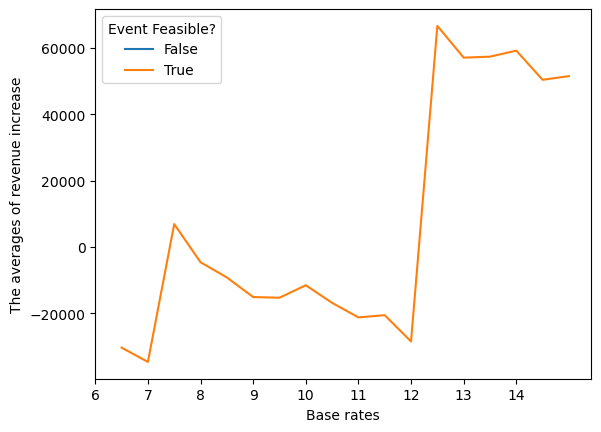

In [145]:
grouped = log_df.groupby(['Base_rate', 'Feasible']).mean().reset_index()

for category, group in grouped.groupby('Feasible'):
    plt.plot(group['Base_rate'], group['Revenue_increase'], label=category)
plt.xlabel('Base rates')
plt.ylabel('The averages of revenue increase')

x_min = 6
x_max = log_df['Base_rate'].max()
plt.xticks(np.arange(x_min, x_max, step=1))

plt.legend(title='Event Feasible?')
plt.show()

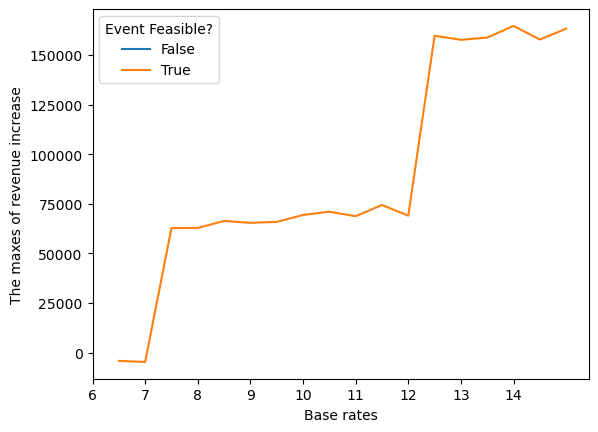

In [144]:
grouped = log_df.groupby(['Base_rate', 'Feasible']).max().reset_index()

for category, group in grouped.groupby('Feasible'):
    plt.plot(group['Base_rate'], group['Revenue_increase'], label=category)
plt.xlabel('Base rates')
plt.ylabel('The maxes of revenue increase')

x_min = 6
x_max = log_df['Base_rate'].max()
plt.xticks(np.arange(x_min, x_max, step=1))

plt.legend(title='Event Feasible?')
plt.show()

In [134]:
best_df

,Age,Previous App Purchases,Price,Cluster,Discount,Discounted Price,Deal
0,37,218,6.0,0,0.05,6.65,0.0
1,34,247,6.0,0,0.05,6.65,0.0
2,19,15,4.0,1,0.45,3.85,1.0
3,32,235,7.0,0,0.05,6.65,1.0
4,19,15,2.5,1,0.45,3.85,0.0
...,...,...,...,...,...,...,...
199995,31,241,0.0,0,0.05,6.65,0.0
199996,25,265,0.0,0,0.05,6.65,0.0
199997,25,259,0.0,0,0.05,6.65,0.0
199998,68,115,0.0,2,0.05,6.65,0.0


In [135]:
best_df[best_df['Discounted Price'] <= best_df['Price']]['Discounted Price'].sum()

127309.00000000004